Upload the applications_base.csv file:


Saving applications_base.csv to applications_base (1).csv
Upload the bureau.csv file:


Saving bureau.csv to bureau (1).csv
Applications Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(62), int64(44), object(16)
memory usage: 952.3+ KB
None
          SK_ID_CURR      TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  \
count     999.000000  999.000000    999.000000        999.000000   
mean   100574.905906    0.070070      0.404404     167648.128784   
std       331.321084    0.255393      0.712486      90211.941543   
min    100002.000000    0.000000      0.000000      31500.000000   
25%    100289.500000    0.000000      0.000000     112500.000000   
50%    100576.000000    0.000000      0.000000     144000.000000   
75%    100861.500000    0.000000      1.000000     202500.000000   
max    101155.000000    1.000000      3.000000     765000.000000   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  9.990000e+02     999.000000     9.980000e+02   
mea

<ipython-input-2-fd1eb34aec34>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df[col] = le.fit_transform(processed_df[col].astype(str))
<ipython-input-2-fd1eb34aec34>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df[col] = le.fit_transform(processed_df[col].astype(str))
<ipython-input-2-fd1eb34aec34>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen


🔹 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       186
           1       0.00      0.00      0.00        14

    accuracy                           0.92       200
   macro avg       0.46      0.49      0.48       200
weighted avg       0.86      0.92      0.89       200

🔹 Random Forest ROC-AUC Score: 0.6240

🔹 XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       186
           1       0.00      0.00      0.00        14

    accuracy                           0.91       200
   macro avg       0.46      0.49      0.48       200
weighted avg       0.86      0.91      0.89       200

🔹 XGBoost ROC-AUC Score: 0.6897


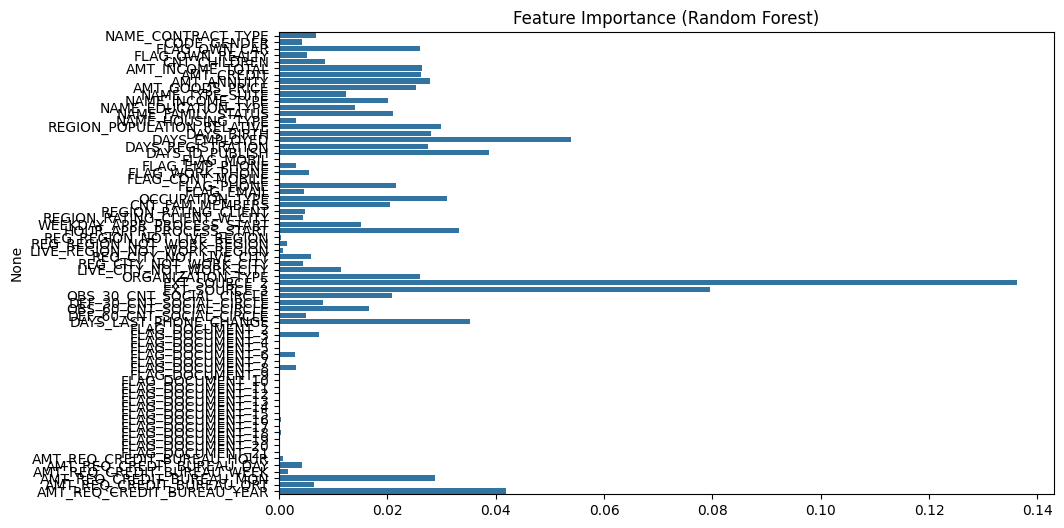

In [2]:
# Install required libraries
!pip install imbalanced-learn xgboost seaborn

# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from google.colab import files

# 📌 Upload datasets
print("Upload the applications_base.csv file:")
uploaded_files_1 = files.upload()

print("Upload the bureau.csv file:")
uploaded_files_2 = files.upload()

# Load data
applications_df = pd.read_csv(next(iter(uploaded_files_1)))
bureau_df = pd.read_csv(next(iter(uploaded_files_2)))

# 📌 Exploratory Data Analysis (EDA)
print("Applications Dataset Overview:")
print(applications_df.info())
print(applications_df.describe())

print("Bureau Dataset Overview:")
print(bureau_df.info())
print(bureau_df.describe())

# 📌 Feature Engineering on Bureau Data
bureau_agg = bureau_df.groupby("SK_ID_CURR").agg(
    num_trades=("SK_ID_BUREAU", "count"),
    num_active_trades=("CREDIT_ACTIVE", lambda x: (x == "Active").sum()),
    num_closed_trades=("CREDIT_ACTIVE", lambda x: (x == "Closed").sum()),
    max_credit_day_overdue=("CREDIT_DAY_OVERDUE", "max"),
    avg_credit_day_overdue=("CREDIT_DAY_OVERDUE", "mean"),
    min_days_credit=("DAYS_CREDIT", "min"),
    avg_days_credit=("DAYS_CREDIT", "mean")
).reset_index()

# 📌 Merge Bureau Data with Applications
merged_df = applications_df.merge(bureau_agg, on="SK_ID_CURR", how="left")

# 📌 Data Cleaning & Encoding
# Drop columns with excessive missing values (>40%)
processed_df = merged_df.dropna(axis=1, thresh=int(0.6 * len(merged_df)))

# Encode categorical features
categorical_cols = processed_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    processed_df[col] = le.fit_transform(processed_df[col].astype(str))

# Fill missing values with median
processed_df.fillna(processed_df.median(), inplace=True)

# 📌 Train-Test Split
X = processed_df.drop(columns=['SK_ID_CURR', 'TARGET'])
y = processed_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 📌 Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 📌 Feature Scaling
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test = scaler.transform(X_test)

# 📌 Train Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=7, random_state=42)
}

# Train and Evaluate Models
for name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n🔹 {name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"🔹 {name} ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# 📌 Feature Importance for Random Forest
best_model = models["Random Forest"]
plt.figure(figsize=(10, 6))
sns.barplot(x=best_model.feature_importances_, y=X.columns)
plt.title("Feature Importance (Random Forest)")
plt.show()
